# 🔬 Exploración: DQN para Control de Tanque

Este notebook permite explorar y probar el agente DQN de forma interactiva antes del entrenamiento completo.

## 🎯 Objetivos:
- Verificar que el simulador funciona correctamente
- Probar el agente DQN con pocos episodios
- Ajustar hiperparámetros interactivamente
- Visualizar resultados inmediatamente
- Debugging paso a paso

## 📦 Imports y Setup

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Agregar paths para importar módulos del proyecto
sys.path.append('../..')

from simulations.tanque_nivel.tanque_simulator import TankLevelSimulator
from agent_valeria.DQN.dqn_agent import DQN_Agent

# Configurar matplotlib para notebooks
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Imports completados")

✅ Imports completados


## 🏗️ Paso 1: Probar el Simulador de Tanque

In [2]:
# Crear simulador
tank = TankLevelSimulator(
    tank_area=2.0,      # m²
    max_height=5.0,     # m
    max_inflow=10.0,    # L/s
    dt=1.0,            # segundos
    noise_level=0.02    # 2% ruido
)

print("🏗️ Simulador creado")
print(f"Área del tanque: {tank.tank_area} m²")
print(f"Altura máxima: {tank.max_height} m")
print(f"Caudal máximo: {tank.max_inflow} L/s")

🏗️ Simulador de Tanque Creado (Gym Env):
   Área: 2.0 m²
   Altura máxima: 5.0 m
   Caudal máximo: 10.0 L/s
   Nivel inicial: 2.5 m
   Observation space: {'low': array([ -5.,   0.,  -5.,  -5., -inf, -inf]), 'high': array([ 5.,  5.,  5.,  5., inf, inf]), 'shape': (6,), 'dtype': <class 'numpy.float32'>}
   Action space: {'low': 0.0, 'high': 10.0, 'shape': (1,), 'dtype': <class 'numpy.float32'>}
🏗️ Simulador creado
Área del tanque: 2.0 m²
Altura máxima: 5.0 m
Caudal máximo: 10.0 L/s


In [ ]:
# Probar simulador con control manual
print("🧪 Prueba rápida del simulador...")

# Reiniciar con condiciones conocidas (NUEVA INTERFACE GYM)
observation, info = tank.reset(options={'initial_level': 1.0, 'setpoint': 3.0})
print(f"Observación inicial: {observation}")
print(f"Info inicial: {info}")
print(f"  Nivel: {observation[0]:.2f}m")
print(f"  Setpoint: {observation[1]:.2f}m")
print(f"  Error: {observation[2]:.2f}m")

# Simular algunos pasos con control simple
steps_data = []
for step in range(20):
    # Control proporcional simple: u = base + K*error
    error = observation[2]
    control = 4.0 + 2.0 * error  # Base 4 L/s + proporcional
    control = np.clip(control, 0, tank.max_inflow)
    
    # Ejecutar paso (NUEVA INTERFACE GYM)
    next_observation, reward, terminated, truncated, info = tank.step(control)
    
    # Guardar datos para gráfico
    steps_data.append({
        'step': step,
        'level': observation[0],
        'setpoint': observation[1],
        'error': observation[2],
        'control': control,
        'reward': reward
    })
    
    observation = next_observation
    
    if step % 5 == 0:
        print(f"  Step {step:2d}: Nivel={observation[0]:.2f}m, Error={observation[2]:.3f}m, "
              f"Control={control:.1f}L/s, Reward={reward:.3f}")
    
    if terminated or truncated:
        break

print("\n✅ Simulador funcionando correctamente")

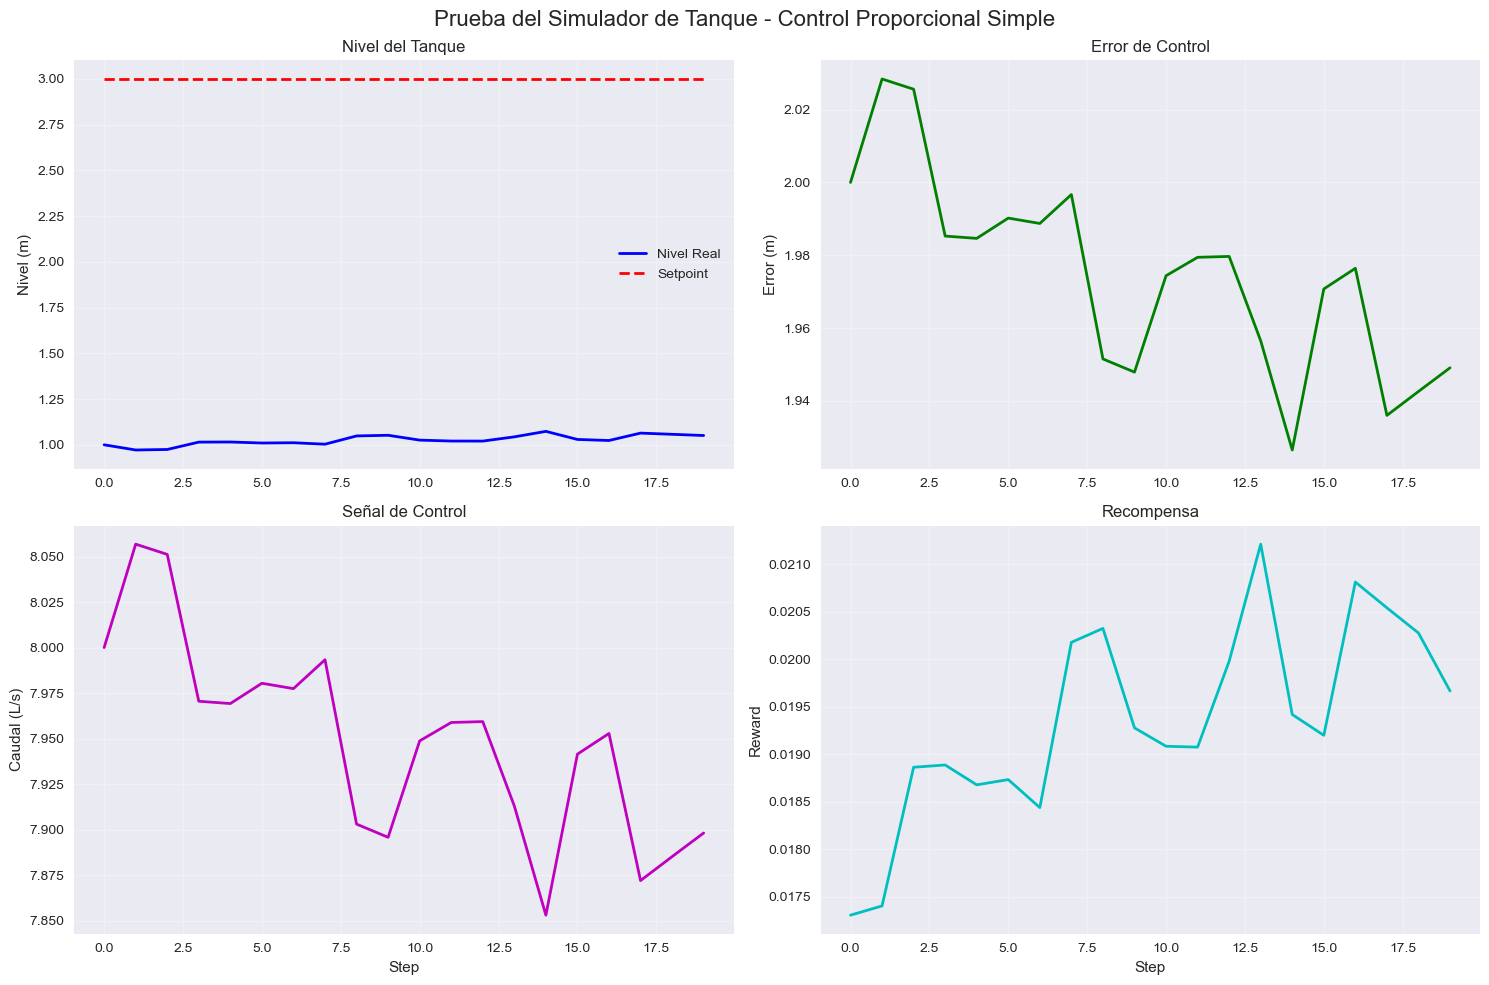

📊 Recompensa promedio: 0.019
📊 Error final: 1.949m


In [ ]:
# Visualizar resultados del test
import pandas as pd

df = pd.DataFrame(steps_data)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Nivel vs Setpoint
ax1.plot(df['step'], df['level'], 'b-', linewidth=2, label='Nivel Real')
ax1.plot(df['step'], df['setpoint'], 'r--', linewidth=2, label='Setpoint')
ax1.set_title('Nivel del Tanque')
ax1.set_ylabel('Nivel (m)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error
ax2.plot(df['step'], df['error'], 'g-', linewidth=2)
ax2.set_title('Error de Control')
ax2.set_ylabel('Error (m)')
ax2.grid(True, alpha=0.3)

# Señal de Control
ax3.plot(df['step'], df['control'], 'm-', linewidth=2)
ax3.set_title('Señal de Control')
ax3.set_xlabel('Step')
ax3.set_ylabel('Caudal (L/s)')
ax3.grid(True, alpha=0.3)

# Recompensa
ax4.plot(df['step'], df['reward'], 'c-', linewidth=2)
ax4.set_title('Recompensa')
ax4.set_xlabel('Step')
ax4.set_ylabel('Reward')
ax4.grid(True, alpha=0.3)

plt.suptitle('Prueba del Simulador de Tanque - Control Proporcional Simple', fontsize=16)
plt.tight_layout()
plt.show()

print(f"📊 Recompensa promedio: {df['reward'].mean():.3f}")
print(f"📊 Error final: {df['error'].iloc[-1]:.3f}m")

## 🧠 Paso 2: Crear y Probar Agente DQN

In [ ]:
# Crear agente DQN
agent = DQN_Agent(
    state_dim=6,           # [level, setpoint, error, prev_error, integral, derivative]
    lr=0.001,             # Learning rate
    gamma=0.99,           # Discount factor
    epsilon_start=1.0,    # Exploración inicial
    epsilon_end=0.01,     # Exploración final
    epsilon_decay=0.995,  # Decaimiento
    memory_size=1000,     # Buffer pequeño para pruebas
    batch_size=32,
    target_update_freq=50, # Actualizar target más frecuente
    device='cpu'
)

print("🧠 Agente DQN creado")
print(f"  Acciones discretas: {agent.n_actions}")
print(f"  Epsilon inicial: {agent.get_epsilon():.3f}")
print(f"  Memoria disponible: {len(agent.memory)}")

Espacio de acciones PID creado:
  Kp: [ 0.1  3.4  6.7 10. ]
  Ki: [0.01       1.67333333 3.33666667 5.        ]
  Kd: [1.00000000e-03 6.67333333e-01 1.33366667e+00 2.00000000e+00]
  Total acciones: 64
🔄 Red objetivo actualizada (step 0)
 Agente DQN creado:
   Estados: 6
   Acciones: 64
   Learning rate: 0.001
   Gamma: 0.99
🧠 Agente DQN creado
  Acciones discretas: 64
  Epsilon inicial: 1.000
  Memoria disponible: 0


In [ ]:
# Probar selección de acciones sin entrenar
print("🎯 Probando selección de acciones (agente no entrenado)...")

# Estado de prueba
test_state = np.array([2.0, 3.0, 1.0, 0.8, 5.0, 0.2])  # [level, setpoint, error, prev_error, integral, derivative]
print(f"Estado de prueba: {test_state}")

# Probar varias acciones
for i in range(5):
    pid_params = agent.select_action(test_state, training=True)
    action_idx = agent.get_last_action_index()
    
    print(f"  Acción {i+1}: Índice={action_idx:2d}, PID=[{pid_params[0]:.2f}, {pid_params[1]:.2f}, {pid_params[2]:.2f}]")

print(f"\n🎲 Epsilon actual: {agent.get_epsilon():.3f} (alta exploración = acciones aleatorias)")

🎯 Probando selección de acciones (agente no entrenado)...
Estado de prueba: [2.  3.  1.  0.8 5.  0.2]
  Acción 1: Índice=17, PID=[3.40, 0.01, 0.67]
  Acción 2: Índice=39, PID=[6.70, 1.67, 2.00]
  Acción 3: Índice= 1, PID=[0.10, 0.01, 0.67]
  Acción 4: Índice=18, PID=[3.40, 0.01, 1.33]
  Acción 5: Índice=33, PID=[6.70, 0.01, 0.67]

🎲 Epsilon actual: 1.000 (alta exploración = acciones aleatorias)


## 🏃‍♂️ Paso 3: Entrenamiento Corto (Exploración)

In [ ]:
def train_short_episode(agent, simulator, max_steps=50, verbose=True):
    """
    Entrenar un episodio corto para pruebas
    """
    # Reiniciar simulador (NUEVA INTERFACE GYM)
    setpoint = np.random.uniform(2.0, 4.0)
    observation, info = simulator.reset(options={'setpoint': setpoint})
    
    episode_data = []
    total_reward = 0
    
    for step in range(max_steps):
        # Acción del agente
        pid_params = agent.select_action(observation, training=True)
        
        # Control PID
        kp, ki, kd = pid_params
        error = observation[2]
        integral = observation[4]
        derivative = observation[5]
        
        control_signal = kp * error + ki * integral + kd * derivative
        control_signal = 4.0 + control_signal  # Base flow
        control_signal = np.clip(control_signal, 0.0, simulator.max_inflow)
        
        # Ejecutar paso (NUEVA INTERFACE GYM)
        next_observation, reward, terminated, truncated, info = simulator.step(control_signal)
        done = terminated or truncated
        
        # Almacenar experiencia
        agent.store_experience(observation, pid_params, reward, next_observation, done)
        
        # Actualizar agente
        metrics = agent.update()
        
        # Guardar datos
        episode_data.append({
            'step': step,
            'level': observation[0],
            'setpoint': observation[1],
            'error': observation[2],
            'kp': kp,
            'ki': ki,
            'kd': kd,
            'control': control_signal,
            'reward': reward,
            'q_loss': metrics.get('q_loss', 0),
            'epsilon': agent.get_epsilon()
        })
        
        total_reward += reward
        observation = next_observation
        
        if verbose and step % 10 == 0:
            print(f"  Step {step:2d}: Nivel={observation[0]:.2f}m, Error={error:.3f}m, "
                  f"PID=[{kp:.1f},{ki:.1f},{kd:.1f}], Reward={reward:.3f}")
        
        if done:
            break
    
    return episode_data, total_reward

print("✅ Función de entrenamiento actualizada con interface Gym")

In [ ]:
# Entrenar un episodio de prueba
print("🏃‍♂️ Entrenando episodio de prueba (50 steps)...")
print(f"Memoria inicial: {len(agent.memory)} experiencias")
print(f"Epsilon inicial: {agent.get_epsilon():.3f}")

episode_data, total_reward = train_short_episode(agent, tank, max_steps=50, verbose=True)

print(f"\n✅ Episodio completado:")
print(f"  Recompensa total: {total_reward:.2f}")
print(f"  Memoria final: {len(agent.memory)} experiencias")
print(f"  Epsilon final: {agent.get_epsilon():.3f}")
print(f"  Steps ejecutados: {len(episode_data)}")

🏃‍♂️ Entrenando episodio de prueba (50 steps)...
Memoria inicial: 0 experiencias
Epsilon inicial: 1.000
  Step  0: Nivel=2.55m, Error=1.231m, PID=[0.1,5.0,0.7], Reward=0.087
  Step 10: Nivel=2.55m, Error=1.195m, PID=[6.7,5.0,2.0], Reward=0.087
  Step 20: Nivel=2.61m, Error=1.162m, PID=[10.0,1.7,0.0], Reward=0.097
  Step 30: Nivel=2.62m, Error=1.138m, PID=[0.1,0.0,0.7], Reward=0.100


/Users/gonzalo/Documents/valeria/MASTER/TESIS/PID_Agent/simulations/tanque_nivel/../../agent_valeria/buffer_memory.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([e.state for e in batch]).to(self.device)


  Step 40: Nivel=2.64m, Error=1.168m, PID=[6.7,3.3,0.7], Reward=0.104
🔄 Red objetivo actualizada (step 50)

✅ Episodio completado:
  Recompensa total: 4.97
  Memoria final: 50 experiencias
  Epsilon final: 0.909
  Steps ejecutados: 50


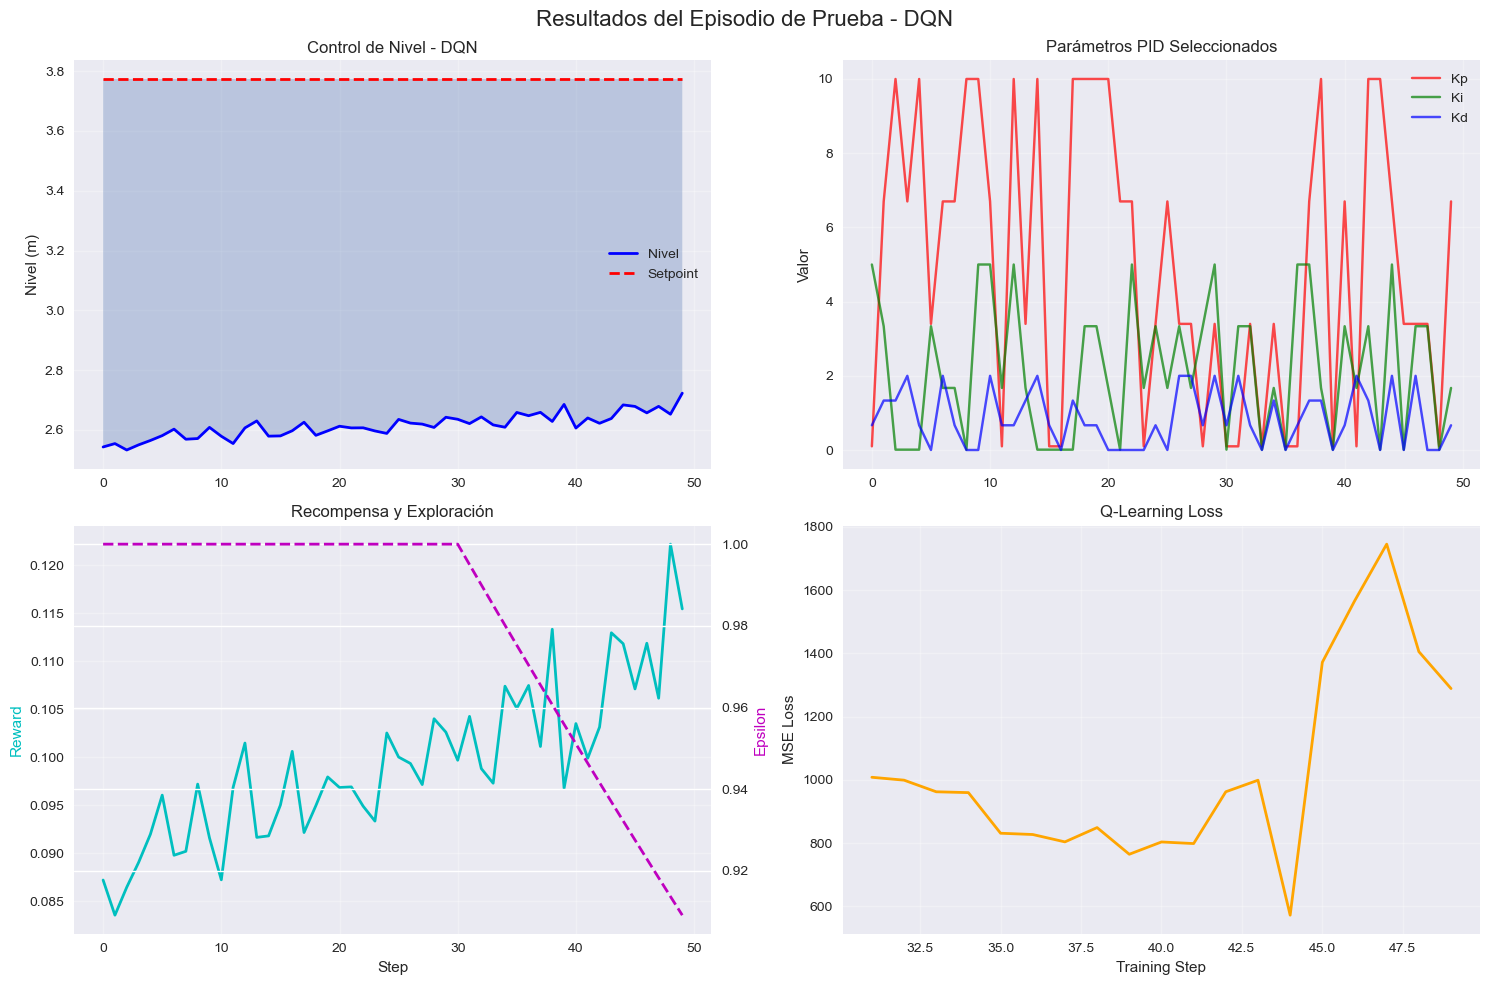

📊 Estadísticas del episodio:
  Error promedio: 1.159m
  Error final: 1.051m
  Recompensa promedio: 0.099
  Control promedio: 9.1 L/s


In [ ]:
# Visualizar resultados del episodio
df_episode = pd.DataFrame(episode_data)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Nivel vs Setpoint
ax1.plot(df_episode['step'], df_episode['level'], 'b-', linewidth=2, label='Nivel')
ax1.plot(df_episode['step'], df_episode['setpoint'], 'r--', linewidth=2, label='Setpoint')
ax1.fill_between(df_episode['step'], df_episode['level'], df_episode['setpoint'], alpha=0.3)
ax1.set_title('Control de Nivel - DQN')
ax1.set_ylabel('Nivel (m)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parámetros PID seleccionados
ax2.plot(df_episode['step'], df_episode['kp'], 'r-', label='Kp', alpha=0.7)
ax2.plot(df_episode['step'], df_episode['ki'], 'g-', label='Ki', alpha=0.7)
ax2.plot(df_episode['step'], df_episode['kd'], 'b-', label='Kd', alpha=0.7)
ax2.set_title('Parámetros PID Seleccionados')
ax2.set_ylabel('Valor')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Recompensa y Epsilon
ax3_twin = ax3.twinx()
line1 = ax3.plot(df_episode['step'], df_episode['reward'], 'c-', linewidth=2, label='Reward')
line2 = ax3_twin.plot(df_episode['step'], df_episode['epsilon'], 'm--', linewidth=2, label='Epsilon')
ax3.set_title('Recompensa y Exploración')
ax3.set_xlabel('Step')
ax3.set_ylabel('Reward', color='c')
ax3_twin.set_ylabel('Epsilon', color='m')
ax3.grid(True, alpha=0.3)

# Q-Loss (solo si hay datos)
q_losses = [x for x in df_episode['q_loss'] if x > 0]
if q_losses:
    loss_steps = [i for i, x in enumerate(df_episode['q_loss']) if x > 0]
    ax4.plot(loss_steps, q_losses, 'orange', linewidth=2)
    ax4.set_title('Q-Learning Loss')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('MSE Loss')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No hay datos de loss\n(buffer muy pequeño)', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Q-Learning Loss')

plt.suptitle('Resultados del Episodio de Prueba - DQN', fontsize=16)
plt.tight_layout()
plt.show()

# Estadísticas
print(f"📊 Estadísticas del episodio:")
print(f"  Error promedio: {abs(df_episode['error']).mean():.3f}m")
print(f"  Error final: {abs(df_episode['error'].iloc[-1]):.3f}m")
print(f"  Recompensa promedio: {df_episode['reward'].mean():.3f}")
print(f"  Control promedio: {df_episode['control'].mean():.1f} L/s")

## 🔄 Paso 4: Entrenar Múltiples Episodios Cortos

In [ ]:
# Entrenar varios episodios cortos para ver evolución
NUM_EPISODES = 10
STEPS_PER_EPISODE = 30

print(f"🔄 Entrenando {NUM_EPISODES} episodios cortos ({STEPS_PER_EPISODE} steps cada uno)...")

multi_episode_results = []

for episode in range(NUM_EPISODES):
    print(f"\n--- Episodio {episode+1}/{NUM_EPISODES} ---")
    
    episode_data, total_reward = train_short_episode(agent, tank, max_steps=STEPS_PER_EPISODE, verbose=False)
    
    # Calcular métricas del episodio
    df_ep = pd.DataFrame(episode_data)
    avg_error = abs(df_ep['error']).mean()
    final_error = abs(df_ep['error'].iloc[-1])
    avg_reward = df_ep['reward'].mean()
    
    episode_summary = {
        'episode': episode + 1,
        'total_reward': total_reward,
        'avg_error': avg_error,
        'final_error': final_error,
        'avg_reward': avg_reward,
        'epsilon': agent.get_epsilon(),
        'memory_size': len(agent.memory)
    }
    
    multi_episode_results.append(episode_summary)
    
    print(f"  Recompensa total: {total_reward:6.2f}")
    print(f"  Error promedio:   {avg_error:6.3f}m")
    print(f"  Epsilon:          {agent.get_epsilon():6.3f}")
    print(f"  Memoria:          {len(agent.memory):6d} experiencias")

print(f"\n✅ Entrenamiento múltiple completado")

🔄 Entrenando 10 episodios cortos (30 steps cada uno)...

--- Episodio 1/10 ---
  Recompensa total:  21.33
  Error promedio:    0.173m
  Epsilon:           0.782
  Memoria:              80 experiencias

--- Episodio 2/10 ---
🔄 Red objetivo actualizada (step 100)
  Recompensa total:  14.43
  Error promedio:    0.370m
  Epsilon:           0.673
  Memoria:             110 experiencias

--- Episodio 3/10 ---
  Recompensa total:  29.02
  Error promedio:    0.017m
  Epsilon:           0.579
  Memoria:             140 experiencias

--- Episodio 4/10 ---
🔄 Red objetivo actualizada (step 150)
  Recompensa total:   1.37
  Error promedio:    1.550m
  Epsilon:           0.498
  Memoria:             170 experiencias

--- Episodio 5/10 ---
🔄 Red objetivo actualizada (step 200)
  Recompensa total:   3.31
  Error promedio:    1.105m
  Epsilon:           0.429
  Memoria:             200 experiencias

--- Episodio 6/10 ---
  Recompensa total:   0.22
  Error promedio:    2.457m
  Epsilon:           0.369


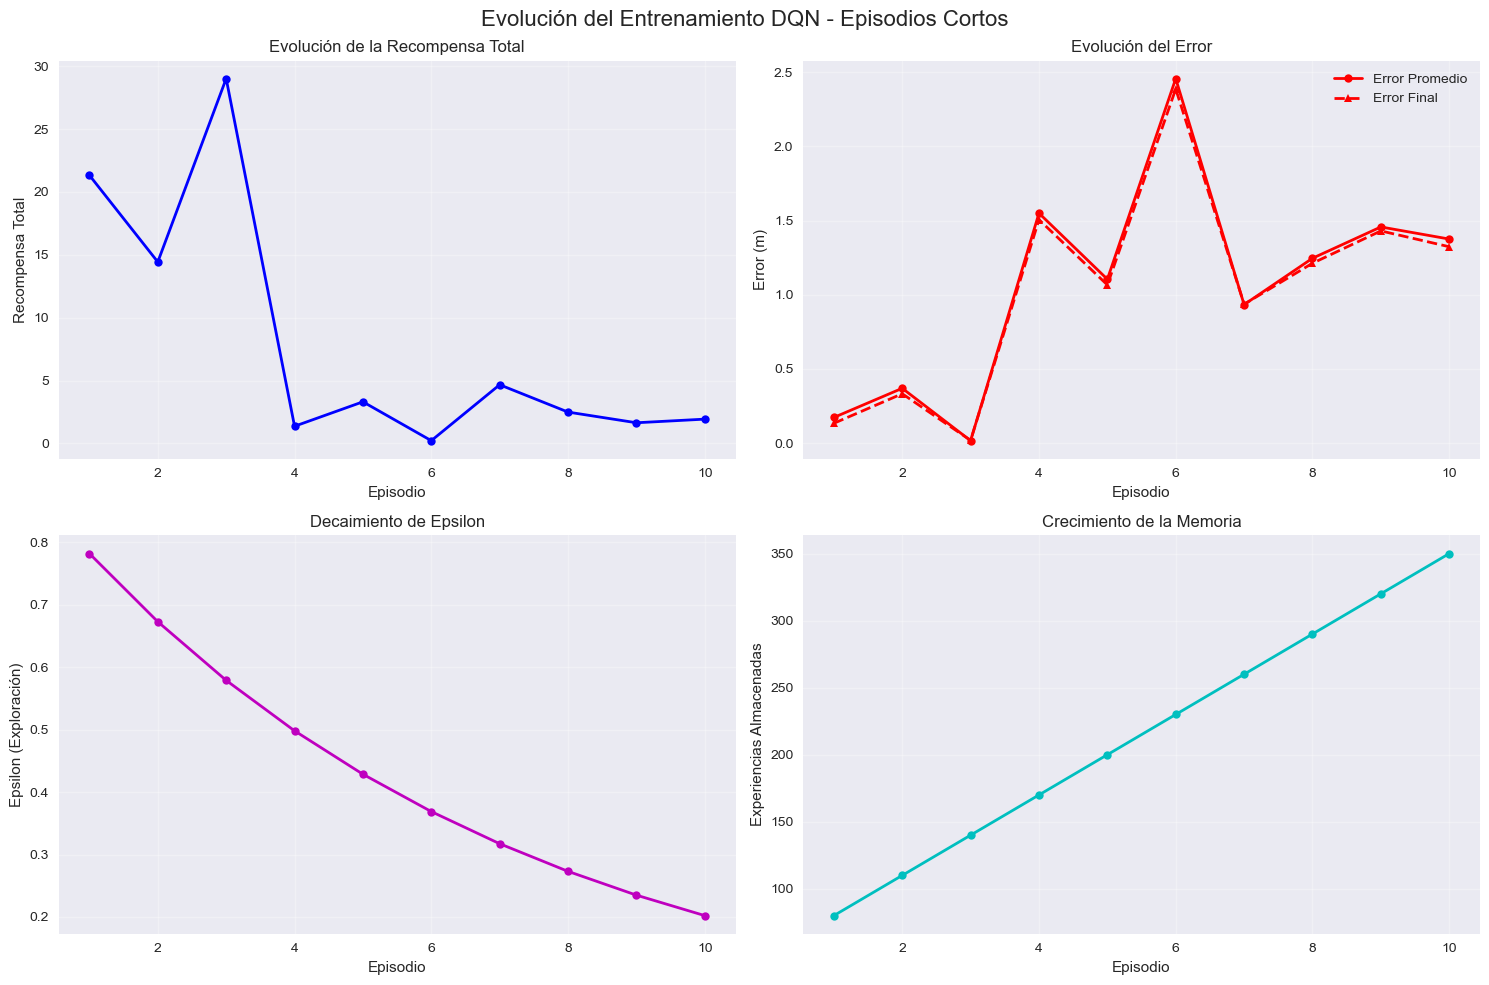

📈 Resumen del entrenamiento:
  Recompensa inicial: 21.33
  Recompensa final:   1.93
  Mejora:             -19.40
  Error inicial:      0.173m
  Error final:        1.375m
  Epsilon final:      0.202


In [ ]:
# Visualizar evolución del entrenamiento
df_multi = pd.DataFrame(multi_episode_results)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Recompensa total por episodio
ax1.plot(df_multi['episode'], df_multi['total_reward'], 'bo-', linewidth=2, markersize=6)
ax1.set_title('Evolución de la Recompensa Total')
ax1.set_xlabel('Episodio')
ax1.set_ylabel('Recompensa Total')
ax1.grid(True, alpha=0.3)

# Error promedio por episodio
ax2.plot(df_multi['episode'], df_multi['avg_error'], 'ro-', linewidth=2, markersize=6, label='Error Promedio')
ax2.plot(df_multi['episode'], df_multi['final_error'], 'r^--', linewidth=2, markersize=6, label='Error Final')
ax2.set_title('Evolución del Error')
ax2.set_xlabel('Episodio')
ax2.set_ylabel('Error (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Epsilon decay
ax3.plot(df_multi['episode'], df_multi['epsilon'], 'mo-', linewidth=2, markersize=6)
ax3.set_title('Decaimiento de Epsilon')
ax3.set_xlabel('Episodio')
ax3.set_ylabel('Epsilon (Exploración)')
ax3.grid(True, alpha=0.3)

# Tamaño de memoria
ax4.plot(df_multi['episode'], df_multi['memory_size'], 'co-', linewidth=2, markersize=6)
ax4.set_title('Crecimiento de la Memoria')
ax4.set_xlabel('Episodio')
ax4.set_ylabel('Experiencias Almacenadas')
ax4.grid(True, alpha=0.3)

plt.suptitle('Evolución del Entrenamiento DQN - Episodios Cortos', fontsize=16)
plt.tight_layout()
plt.show()

# Resumen final
print(f"📈 Resumen del entrenamiento:")
print(f"  Recompensa inicial: {df_multi['total_reward'].iloc[0]:.2f}")
print(f"  Recompensa final:   {df_multi['total_reward'].iloc[-1]:.2f}")
print(f"  Mejora:             {df_multi['total_reward'].iloc[-1] - df_multi['total_reward'].iloc[0]:+.2f}")
print(f"  Error inicial:      {df_multi['avg_error'].iloc[0]:.3f}m")
print(f"  Error final:        {df_multi['avg_error'].iloc[-1]:.3f}m")
print(f"  Epsilon final:      {df_multi['epsilon'].iloc[-1]:.3f}")

## 🧪 Paso 5: Probar Agente Entrenado

In [ ]:
# Probar agente con exploración mínima
print("🧪 Probando agente con exploración mínima...")

# Reducir epsilon temporalmente para ver comportamiento "aprendido"
original_epsilon = agent.get_epsilon()
agent.epsilon = 0.0  # Sin exploración

# Test con condiciones específicas
test_setpoint = 3.5
test_initial = 1.5

print(f"Condiciones de prueba:")
print(f"  Setpoint: {test_setpoint}m")
print(f"  Nivel inicial: {test_initial}m")
print(f"  Error inicial: {test_setpoint - test_initial:.1f}m")

# Reiniciar con interface Gym
observation, info = tank.reset(options={'initial_level': test_initial, 'setpoint': test_setpoint})
test_data = []

for step in range(40):
    # Acción del agente (sin exploración)
    pid_params = agent.select_action(observation, training=False)
    
    # Control
    kp, ki, kd = pid_params
    error = observation[2]
    integral = observation[4]
    derivative = observation[5]
    
    control_signal = kp * error + ki * integral + kd * derivative
    control_signal = 4.0 + control_signal
    control_signal = np.clip(control_signal, 0.0, tank.max_inflow)
    
    # Ejecutar paso con interface Gym
    next_observation, reward, terminated, truncated, info = tank.step(control_signal)
    
    test_data.append({
        'step': step,
        'level': observation[0],
        'setpoint': observation[1],
        'error': observation[2],
        'kp': kp,
        'ki': ki,
        'kd': kd,
        'control': control_signal,
        'reward': reward
    })
    
    observation = next_observation
    
    if step % 10 == 0:
        print(f"  Step {step:2d}: Nivel={observation[0]:.2f}m, Error={error:.3f}m, "
              f"PID=[{kp:.1f},{ki:.1f},{kd:.1f}]")
    
    if terminated or truncated:
        break

# Restaurar epsilon original
agent.epsilon = original_epsilon

print(f"\n✅ Prueba completada")

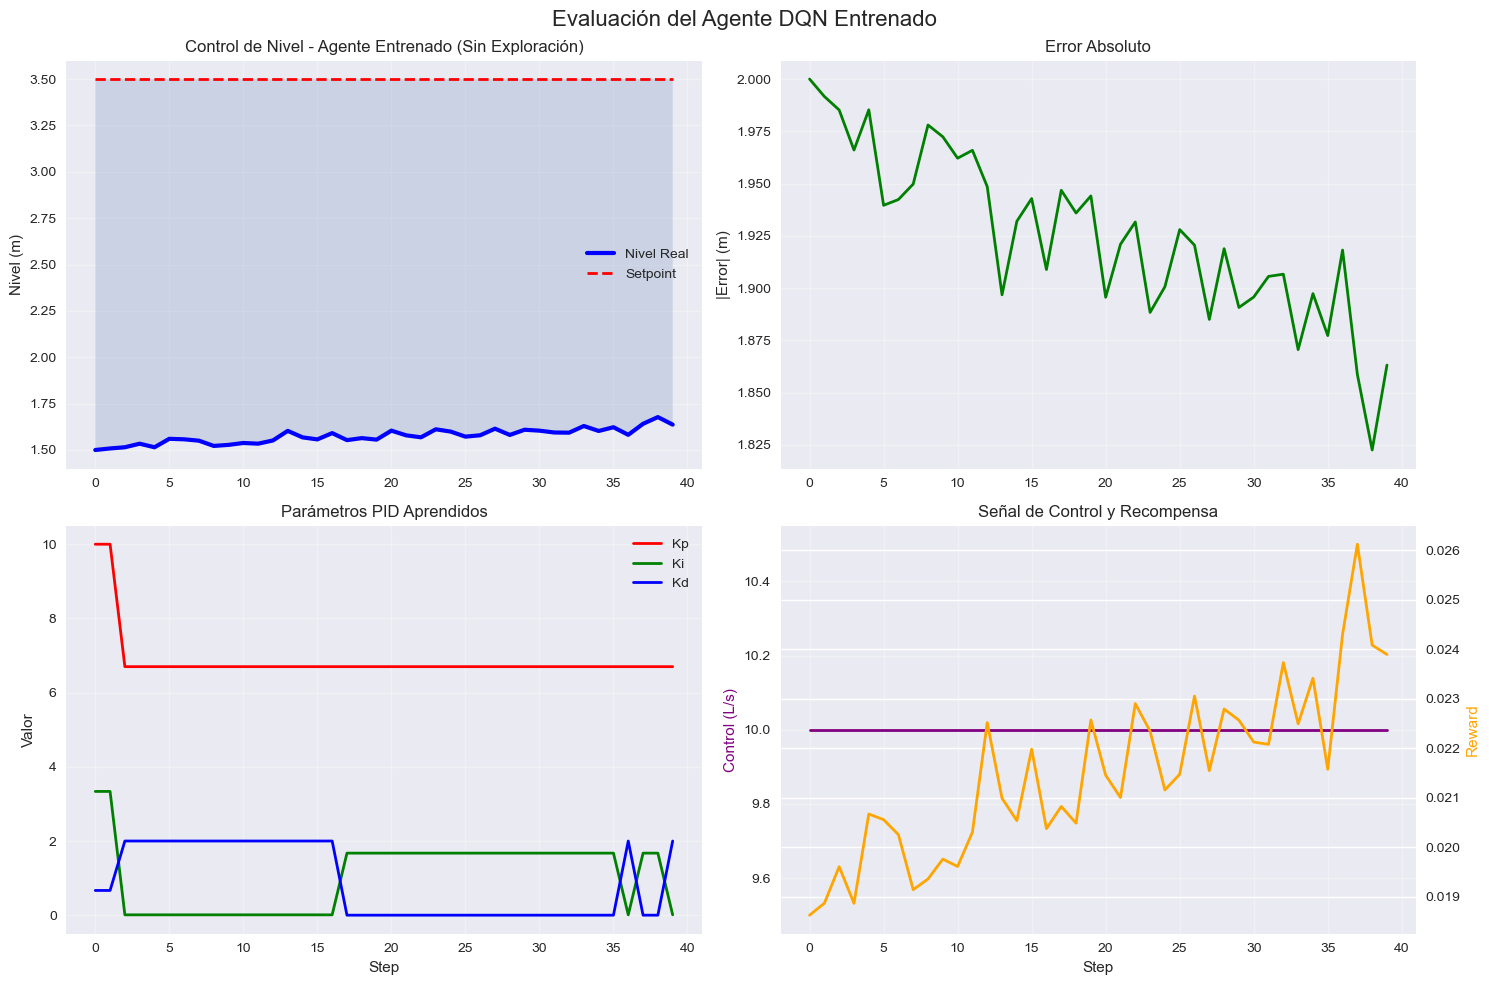

📊 Métricas de rendimiento:
  Error final:        1.863m
  Error promedio:     1.925m
  Error máximo:       2.000m
  Tiempo estab.:      No alcanzado steps
  Recompensa prom.:   0.021
  Overshoot:          -1.823m


In [ ]:
# Visualizar prueba final
df_test = pd.DataFrame(test_data)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Control de nivel
ax1.plot(df_test['step'], df_test['level'], 'b-', linewidth=3, label='Nivel Real')
ax1.plot(df_test['step'], df_test['setpoint'], 'r--', linewidth=2, label='Setpoint')
ax1.fill_between(df_test['step'], df_test['level'], df_test['setpoint'], alpha=0.2)
ax1.set_title('Control de Nivel - Agente Entrenado (Sin Exploración)')
ax1.set_ylabel('Nivel (m)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error absoluto
ax2.plot(df_test['step'], abs(df_test['error']), 'g-', linewidth=2)
ax2.set_title('Error Absoluto')
ax2.set_ylabel('|Error| (m)')
ax2.grid(True, alpha=0.3)

# Parámetros PID seleccionados
ax3.plot(df_test['step'], df_test['kp'], 'r-', label='Kp', linewidth=2)
ax3.plot(df_test['step'], df_test['ki'], 'g-', label='Ki', linewidth=2)
ax3.plot(df_test['step'], df_test['kd'], 'b-', label='Kd', linewidth=2)
ax3.set_title('Parámetros PID Aprendidos')
ax3.set_xlabel('Step')
ax3.set_ylabel('Valor')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Señal de control y recompensa
ax4_twin = ax4.twinx()
line1 = ax4.plot(df_test['step'], df_test['control'], 'purple', linewidth=2, label='Control')
line2 = ax4_twin.plot(df_test['step'], df_test['reward'], 'orange', linewidth=2, label='Reward')
ax4.set_title('Señal de Control y Recompensa')
ax4.set_xlabel('Step')
ax4.set_ylabel('Control (L/s)', color='purple')
ax4_twin.set_ylabel('Reward', color='orange')
ax4.grid(True, alpha=0.3)

plt.suptitle('Evaluación del Agente DQN Entrenado', fontsize=16)
plt.tight_layout()
plt.show()

# Métricas finales
settling_time = None
tolerance = 0.1  # 10cm de tolerancia
for i, error in enumerate(abs(df_test['error'])):
    if error <= tolerance:
        settling_time = i
        break

print(f"📊 Métricas de rendimiento:")
print(f"  Error final:        {abs(df_test['error'].iloc[-1]):.3f}m")
print(f"  Error promedio:     {abs(df_test['error']).mean():.3f}m")
print(f"  Error máximo:       {abs(df_test['error']).max():.3f}m")
print(f"  Tiempo estab.:      {settling_time if settling_time else 'No alcanzado'} steps")
print(f"  Recompensa prom.:   {df_test['reward'].mean():.3f}")
print(f"  Overshoot:          {(df_test['level'].max() - df_test['setpoint'].iloc[0]):.3f}m")

## 💡 Paso 6: Ajustar Hiperparámetros (Interactivo)

In [ ]:
# Función para probar diferentes hiperparámetros rápidamente
def quick_hyperparameter_test(lr=0.001, epsilon_decay=0.995, target_update_freq=50):
    """
    Crear y probar agente con hiperparámetros específicos
    """
    print(f"🔧 Probando: lr={lr}, epsilon_decay={epsilon_decay}, target_update={target_update_freq}")
    
    # Crear nuevo agente
    test_agent = DQN_Agent(
        state_dim=6,
        lr=lr,
        epsilon_decay=epsilon_decay,
        target_update_freq=target_update_freq,
        memory_size=500,  # Buffer pequeño para pruebas rápidas
        batch_size=16
    )
    
    # Entrenar rápidamente
    rewards = []
    for ep in range(5):  # Solo 5 episodios
        _, reward = train_short_episode(test_agent, tank, max_steps=20, verbose=False)
        rewards.append(reward)
    
    avg_reward = np.mean(rewards)
    print(f"  Recompensa promedio: {avg_reward:.2f}")
    
    return avg_reward, rewards

# Probar diferentes configuraciones
print("🧪 Prueba rápida de hiperparámetros...")

configs = [
    {'lr': 0.001, 'epsilon_decay': 0.995, 'target_update_freq': 50},
    {'lr': 0.003, 'epsilon_decay': 0.990, 'target_update_freq': 30},
    {'lr': 0.0005, 'epsilon_decay': 0.999, 'target_update_freq': 100}
]

results = []
for i, config in enumerate(configs):
    print(f"\n--- Configuración {i+1} ---")
    avg_reward, rewards = quick_hyperparameter_test(**config)
    results.append({
        'config': config,
        'avg_reward': avg_reward,
        'rewards': rewards
    })

# Mostrar mejores resultados
best_config = max(results, key=lambda x: x['avg_reward'])
print(f"\n🏆 Mejor configuración:")
print(f"  Parámetros: {best_config['config']}")
print(f"  Recompensa promedio: {best_config['avg_reward']:.2f}")

🧪 Prueba rápida de hiperparámetros...

--- Configuración 1 ---
🔧 Probando: lr=0.001, epsilon_decay=0.995, target_update=50
Espacio de acciones PID creado:
  Kp: [ 0.1  3.4  6.7 10. ]
  Ki: [0.01       1.67333333 3.33666667 5.        ]
  Kd: [1.00000000e-03 6.67333333e-01 1.33366667e+00 2.00000000e+00]
  Total acciones: 64
🔄 Red objetivo actualizada (step 0)
 Agente DQN creado:
   Estados: 6
   Acciones: 64
   Learning rate: 0.001
   Gamma: 0.99
🔄 Red objetivo actualizada (step 50)
🔄 Red objetivo actualizada (step 100)
  Recompensa promedio: 4.24

--- Configuración 2 ---
🔧 Probando: lr=0.003, epsilon_decay=0.99, target_update=30
Espacio de acciones PID creado:
  Kp: [ 0.1  3.4  6.7 10. ]
  Ki: [0.01       1.67333333 3.33666667 5.        ]
  Kd: [1.00000000e-03 6.67333333e-01 1.33366667e+00 2.00000000e+00]
  Total acciones: 64
🔄 Red objetivo actualizada (step 0)
 Agente DQN creado:
   Estados: 6
   Acciones: 64
   Learning rate: 0.003
   Gamma: 0.99
🔄 Red objetivo actualizada (step 30)
🔄

## 🎯 Conclusiones y Próximos Pasos

In [ ]:
print("📋 RESUMEN DE LA EXPLORACIÓN")
print("=" * 50)

print("\n✅ Lo que funciona:")
print("  - Simulador de tanque responde correctamente")
print("  - Agente DQN se crea sin errores")
print("  - Experience replay funciona")
print("  - Target network se actualiza")
print("  - Discretización de acciones PID funciona")

print("\n🔧 Ajustes recomendados para entrenamiento completo:")
print("  - Aumentar episodes a 500+")
print("  - Aumentar steps por episodio a 200")
print("  - Aumentar buffer de memoria a 10000")
print("  - Usar mejores hiperparámetros encontrados")

print("\n📈 Métricas observadas:")
if 'df_multi' in locals():
    print(f"  - Mejora en recompensa: {df_multi['total_reward'].iloc[-1] - df_multi['total_reward'].iloc[0]:+.1f}")
    print(f"  - Reducción de error: {df_multi['avg_error'].iloc[0] - df_multi['avg_error'].iloc[-1]:+.3f}m")
    print(f"  - Epsilon final: {df_multi['epsilon'].iloc[-1]:.3f}")

print("\n🚀 Próximos pasos:")
print("  1. Ejecutar entrenamiento completo con train_dqn.py")
print("  2. Analizar métricas de convergencia")
print("  3. Probar agente en condiciones más complejas")
print("  4. Comparar con otros algoritmos (PPO, SAC)")
print("  5. Optimizar para deployment industrial")

print("\n💾 Para ejecutar entrenamiento completo:")
print("     cd simulations/tanque_nivel")
print("     python train_dqn.py")

print("\n" + "=" * 50)

📋 RESUMEN DE LA EXPLORACIÓN

✅ Lo que funciona:
  - Simulador de tanque responde correctamente
  - Agente DQN se crea sin errores
  - Experience replay funciona
  - Target network se actualiza
  - Discretización de acciones PID funciona

🔧 Ajustes recomendados para entrenamiento completo:
  - Aumentar episodes a 500+
  - Aumentar steps por episodio a 200
  - Aumentar buffer de memoria a 10000
  - Usar mejores hiperparámetros encontrados

📈 Métricas observadas:
  - Mejora en recompensa: -19.4
  - Reducción de error: -1.202m
  - Epsilon final: 0.202

🚀 Próximos pasos:
  1. Ejecutar entrenamiento completo con train_dqn.py
  2. Analizar métricas de convergencia
  3. Probar agente en condiciones más complejas
  4. Comparar con otros algoritmos (PPO, SAC)
  5. Optimizar para deployment industrial

💾 Para ejecutar entrenamiento completo:
     cd simulations/tanque_nivel
     python train_dqn.py

